In [2]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.special import erf

In [102]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1

R_um_nsphere = 0.05

N_T_usphere = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
N_T_nsphere = 0.5 * ( 4/3 * np.pi * (R_um_nsphere*1e-6)**3) * rho_T/mAMU


q_thr = 0.15e9    # momentum threshold, eV

In [4]:
rhoDM = 0.3e9        # dark matter mass density, eV/cm^3

vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

In [5]:
def f_halo(v):
    """
    DM velocity distribution in the Earth frame
    
    :param v: input velocity (array-like)
    :return: velocity distribtuion (array-like)
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    
    # v < (vesc - ve)
    f1 = np.exp( - (v+ve)**2 / v0**2 ) * (np.exp(4*v*ve / v0**2) - 1)
    # (vesc - ve) < v < (vesc + ve)
    f2 = np.exp( - (v-ve)**2 / v0**2 ) - np.exp(- vesc**2 / v0**2)

    f = np.zeros_like(v)
    g1 = v < (vesc - ve)
    g2 = np.logical_and( vesc-ve < v, v < vesc + ve)
    
    f[g1] = f1[g1]
    f[g2] = f2[g2]

    return f * np.pi * v * v0**2 / (N0 * ve)

def f_halo_dan(v):
    """
    I think this is the 1-D standard halo model but need to double check.
    See Eq. (2) of https://link.aps.org/doi/10.1103/PhysRevD.42.3572
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    return 4 * np.pi * v**2 * np.exp(-v**2 / v0**2) / N0

In [12]:
def dsig_domega_born(mx, mphi, alpha, q, point_charge):
    point_charge_sol = (4 * (mx**2) * (alpha**2) ) / ( (mphi**2 + q**2)**2 )
    if point_charge:
        return point_charge_sol
    else:
        form_factor = 3 * spherical_jn(n=1, z=q*R) / (q * R)
        return point_charge_sol * form_factor**2
    
def dsig_dq(dsigdomega, mx, alpha, q, vlist, q_thr):

    ss = np.empty(shape=(vlist.size, q.size))

    for i, v in enumerate(vlist):
        p = mx * v
        dsigdq = ( 2 * np.pi * q / (p**2) ) * dsigdomega

        # Cut off contribution below detection threshold
        dsigdq[q < q_thr] = 0

        Ecm = 0.5 * mx * v**2

        # Events outside of sphere only
        bmin = 5e-4 / hbarc # 5 um radius
        qmax = 2 * mx * v / np.sqrt(4 * Ecm**2 * bmin**2 / alpha**2 + 1)
        dsigdq[q > qmax] = 0

        # Account for vmin at a given q
        dsigdq[q > 2 * mx * v] = 0
        
        ss[i] = dsigdq
        
    return ss

def dR_dq(mx, mphi, alpha, q, vlist, q_thr):
    # Differential cross section
    dsigdomega = dsig_domega_born(mx, mphi, alpha, q, point_charge=True)
    dsigdq = dsig_dq(dsigdomega, mx, alpha, q, vlist, q_thr)
        
    int_vec = rhoDM / mx * vlist * f_halo_dan(vlist)
    
    drdq = np.empty_like(q)
    for i in range(q.size):
        drdq[i] = np.trapz( int_vec * dsigdq.T[i], x=vlist )
        
    conv_fac = hbarc**2 * 1e9 * 3e10 * 1e-8 * 3600  # natural units -> um^2/GeV, c [cm/s], um^2/cm^2, s/hr
    
    # Counts/hour/GeV
    return drdq * conv_fac

## Upper limits

First try: model the experiment as Poisson counting.

Assume that we observe 0 events. The 95% CL upper limit is set at the parameters that gives an average of 3 events during the exposure.

In [103]:
outdir = r"C:\Users\yuhan\work\microspheres\code\impulse\data\massless_mediator"
rate = np.load(outdir+'\event_rate_150MeV_10um.npz', allow_pickle='True')
mx, alpha, event_rate = rate['mx'], rate['alpha'], rate['rate']

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\3606613902.py:2: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx/1e9, 4*np.pi*alpha/N_T, np.log(event_rate.T))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

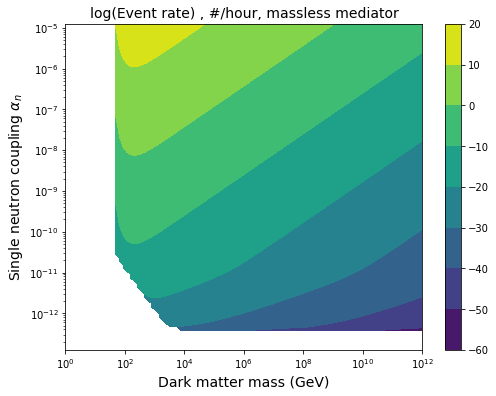

In [104]:
plt.figure(figsize=(8, 6))
plt.contourf(mx/1e9, 4*np.pi*alpha/N_T, np.log(event_rate.T))
plt.colorbar()
plt.yscale('log')
plt.xscale('log')

plt.title(r'log(Event rate) , #/hour, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\3059689993.py:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx/1e9, 4*np.pi*alpha/N_T_usphere, np.log(events))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

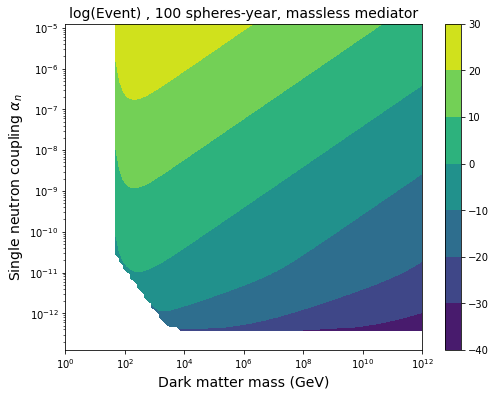

In [105]:
exposure = 100*24*365  # 1 sphere-hour -> 100 spheres-year

events = event_rate.T * exposure

plt.figure(figsize=(8, 6))
plt.contourf(mx/1e9, 4*np.pi*alpha/N_T_usphere, np.log(events))
plt.colorbar()
plt.yscale('log')
plt.xscale('log')

plt.title(r'log(Event) , 100 spheres-year, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

In [122]:
def get_limit(mx, alpha_n, events):
    cl = 3.0  # 95% CL without background
    
    ret = np.empty_like(mx)
    # Solve for parameters where `events` = cl
    for i, m in enumerate(mx):
        if np.sum(events[i]) < 1e-5:
            ret[i] = np.nan
        else:
            min_alpha_idx = np.argmin( np.abs(events[i] - cl) )
            ret[i] = alpha_n[min_alpha_idx]
    
    return ret

In [79]:
exposure = 100 * 24 * 365  # 1 sphere-hour -> 100 spheres-year
alpha_95 = get_limit(mx/1e9, 4*np.pi*alpha/N_T, event_rate.T, exposure)

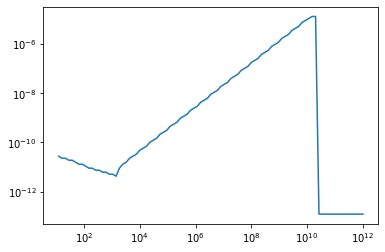

In [80]:
plt.plot(mx/1e9, alpha_95)

plt.xscale('log')
plt.yscale('log')

## Nanospheres

In [114]:
def get_events(rate, nt, exposure):
    mx, alpha, event_rate = rate['mx'], rate['alpha'], rate['rate']
        
    mx_gev = mx / 1e9
    alpha_n = 4 * np.pi * alpha / nt
    events = event_rate.T * exposure

    return mx_gev, alpha_n, events

In [191]:
outdir = r"C:\Users\yuhan\work\microspheres\code\impulse\data\massless_mediator"
rate_100kev = np.load(outdir+'\event_rate_100keV_100nm.npz', allow_pickle='True')
mx, alpha, event_rate = rate_100kev['mx'], rate_100kev['alpha'], rate_100kev['rate']

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\2376051539.py:2: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx/1e9, 4*np.pi*alpha/N_T_nsphere, np.log(event_rate.T))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

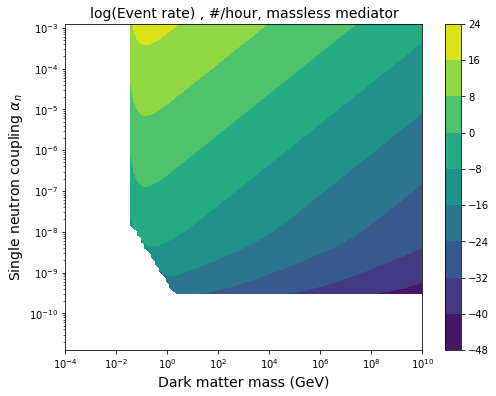

In [192]:
plt.figure(figsize=(8, 6))
plt.contourf(mx/1e9, 4*np.pi*alpha/N_T_nsphere, np.log(event_rate.T))
plt.colorbar()
plt.yscale('log')
plt.xscale('log')

plt.title(r'log(Event rate) , #/hour, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\513172148.py:5: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx_gev_100kev, alpha_n_100kev, np.log(events_100kev))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

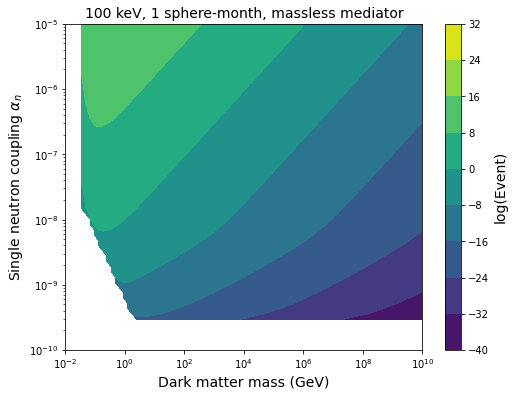

In [193]:
exposure = 24 * 30  # 1 sphere-hour -> 1 spheres-month
mx_gev_100kev, alpha_n_100kev, events_100kev = get_events(rate_100kev, N_T_nsphere, exposure)

plt.figure(figsize=(8, 6))
plt.contourf(mx_gev_100kev, alpha_n_100kev, np.log(events_100kev))
plt.colorbar().set_label(label='log(Event)', size=14)
plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-2, 1e10)
plt.ylim(1e-10, 1e-5)

plt.title(r'100 keV, 1 sphere-month, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

In [194]:
aa = get_limit(mx_gev_100kev, alpha_n_100kev, events_100kev)

In [166]:
alpha_n_100kev

array([1.25663706e-13, 1.51362379e-13, 1.82316521e-13, 2.19600895e-13,
       2.64510056e-13, 3.18603299e-13, 3.83758801e-13, 4.62238835e-13,
       5.56768313e-13, 6.70629404e-13, 8.07775491e-13, 9.72968439e-13,
       1.17194393e-12, 1.41161061e-12, 1.70028998e-12, 2.04800530e-12,
       2.46682963e-12, 2.97130503e-12, 3.57894742e-12, 4.31085484e-12,
       5.19243992e-12, 6.25431227e-12, 7.53334127e-12, 9.07393623e-12,
       1.09295883e-11, 1.31647278e-11, 1.58569613e-11, 1.90997660e-11,
       2.30057357e-11, 2.77104901e-11, 3.33773835e-11, 4.02031765e-11,
       4.84248685e-11, 5.83279255e-11, 7.02561928e-11, 8.46238329e-11,
       1.01929706e-10, 1.22774692e-10, 1.47882551e-10, 1.78125057e-10,
       2.14552261e-10, 2.58428958e-10, 3.11278595e-10, 3.74936170e-10,
       4.51611944e-10, 5.43968186e-10, 6.55211605e-10, 7.89204698e-10,
       9.50599853e-10, 1.14500089e-09, 1.37915762e-09, 1.66120024e-09,
       2.00092157e-09, 2.41011712e-09, 2.90299460e-09, 3.49666727e-09,
      

(0.01, 10000000000.0)

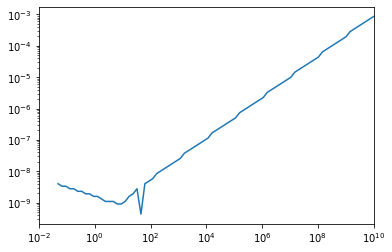

In [195]:
plt.loglog(mx_gev_100kev, aa)
plt.xlim(1e-2, 1e10)

In [167]:
rate_50kev = np.load(outdir+'\event_rate_50keV_100nm.npz', allow_pickle='True')
exposure = 24 * 30  # 1 sphere-hour -> 1 spheres-month
mx_gev, alpha_n, events_50kev = get_events(rate_50kev, N_T_nsphere, exposure)

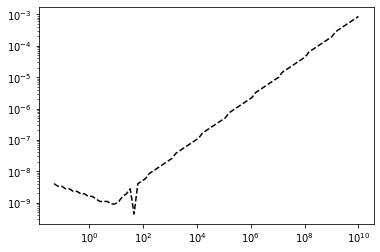

In [128]:
plt.loglog(mx_gev, aa, 'k--')

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\469404364.py:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx_gev, alpha_n, np.log(events))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

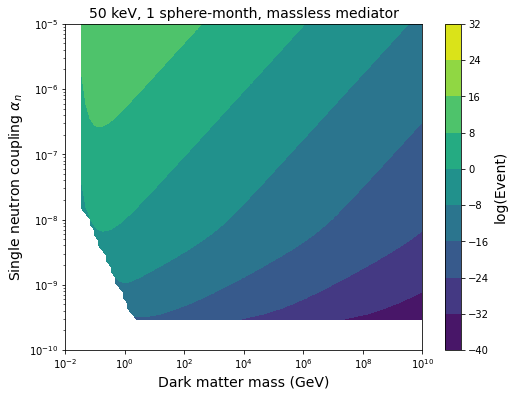

In [119]:
plt.figure(figsize=(8, 6))
plt.contourf(mx_gev, alpha_n, np.log(events))
plt.colorbar().set_label(label='log(Event)', size=14)
plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-2, 1e10)
plt.ylim(1e-10, 1e-5)

plt.title(r'50 keV, 1 sphere-month, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\950209811.py:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx_gev, alpha_n, np.log(events))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

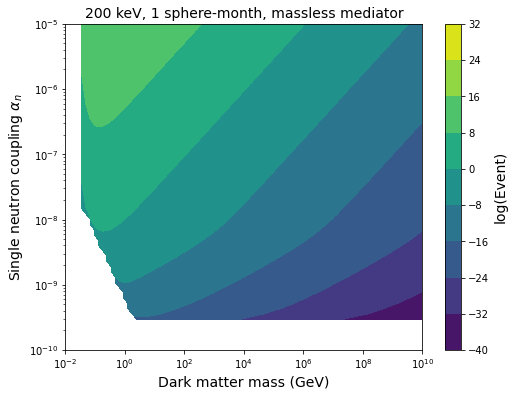

In [172]:
rate_200kev = np.load(outdir+'\event_rate_200keV_100nm.npz', allow_pickle='True')
exposure = 24 * 30  # 1 sphere-hour -> 1 spheres-month
mx_gev, alpha_n, events_200kev = get_events(rate_200kev, N_T_nsphere, exposure)

plt.figure(figsize=(8, 6))
plt.contourf(mx_gev, alpha_n, np.log(events))
plt.colorbar().set_label(label='log(Event)', size=14)
plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-2, 1e10)
plt.ylim(1e-10, 1e-5)

plt.title(r'200 keV, 1 sphere-month, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\1808593781.py:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx_gev, alpha_n, np.log(events))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

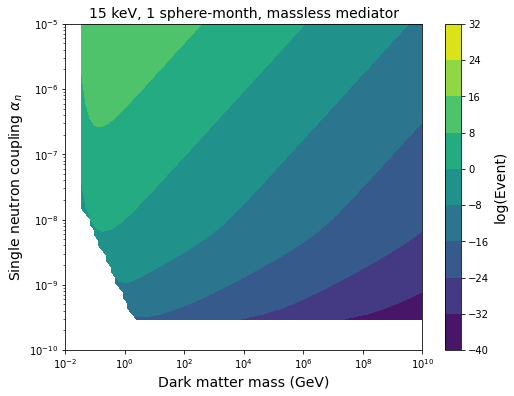

In [187]:
rate_15kev = np.load(outdir+'\event_rate_15keV_100nm.npz', allow_pickle='True')
exposure = 24 * 30  # 1 sphere-hour -> 1 spheres-month
mx_gev, alpha_n, events_15kev = get_events(rate_15kev, N_T_nsphere, exposure)

plt.figure(figsize=(8, 6))
plt.contourf(mx_gev, alpha_n, np.log(events))
plt.colorbar().set_label(label='log(Event)', size=14)
plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-2, 1e10)
plt.ylim(1e-10, 1e-5)

plt.title(r'15 keV, 1 sphere-month, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_19372\1921672214.py:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(mx_gev, alpha_n, np.log(events))


Text(0, 0.5, 'Single neutron coupling $\\alpha_n$')

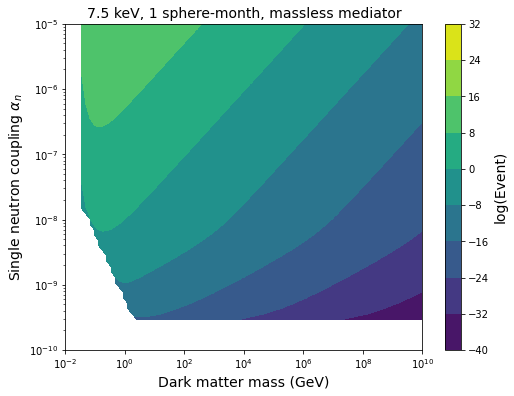

In [174]:
rate_7_5kev = np.load(outdir+'\event_rate_7_5keV_100nm.npz', allow_pickle='True')
exposure = 24 * 30  # 1 sphere-hour -> 1 spheres-month
mx_gev, alpha_n, events_7_5kev = get_events(rate_7_5kev, N_T_nsphere, exposure)

plt.figure(figsize=(8, 6))
plt.contourf(mx_gev, alpha_n, np.log(events))
plt.colorbar().set_label(label='log(Event)', size=14)
plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-2, 1e10)
plt.ylim(1e-10, 1e-5)

plt.title(r'7.5 keV, 1 sphere-month, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

In [196]:
limit_100kev = get_limit(mx_gev, alpha_n, events_100kev)
limit_200kev = get_limit(mx_gev, alpha_n, events_200kev)
limit_50kev = get_limit(mx_gev, alpha_n, events_50kev)
limit_15kev = get_limit(mx_gev, alpha_n, events_15kev)
limit_7_5kev = get_limit(mx_gev, alpha_n, events_7_5kev)

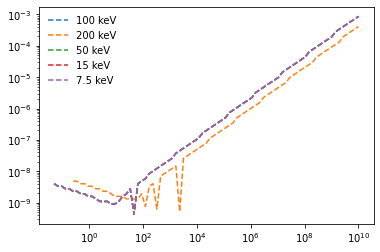

In [199]:
plt.plot(mx_gev, limit_100kev, '--', label='100 keV')
plt.plot(mx_gev, limit_200kev, '--', label='200 keV')
plt.plot(mx_gev, limit_50kev, '--', label='50 keV')
plt.plot(mx_gev, limit_15kev, '--', label='15 keV')
plt.plot(mx_gev, limit_7_5kev, '--', label='7.5 keV')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)

In [190]:
events_50kev[50] - events_15kev[50]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 20230519

In [24]:
npts = 10
mx_gev = np.logspace(-4, 10, npts)
alpha_t = np.logspace(-12, -4, npts)

In [25]:
i = 5
mx = mx_gev[i]
alpha = alpha_t[i]

outdir = r"C:\Users\yuhan\work\microspheres\code\impulse\data\massless_mediator"
data = np.load(outdir + f'\drdq_nanosphere_{mx:.5e}_{alpha:.5e}.npz', allow_pickle='True')

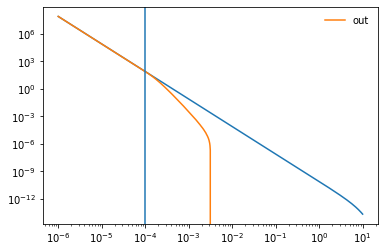

In [27]:
plt.plot( data['q'], data['drdq'] )
plt.plot( data['q'], data['drdq_out'], label='out')
q_thr = 100e3 / 1e9
plt.axvline(x = q_thr)

plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')

5994.8425031894085